In [1]:
# 상위 폴더 경로 가져오기.
from example_base import GetParentPath
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread

In [2]:
# 1개 로봇을 연결하는 인스턴스 생성.
PingPongThreadInstance = PingPongThread(number=1, group_id=4)
# 로봇 제어 쓰레드 시작.
PingPongThreadInstance.start()
# 모든 로봇이 연결될 때 까지 기다림.
PingPongThreadInstance.wait_until_full_connect()

Found device: nRF Connect USB CDC ACM(COM12)
Serial connected.Write data: DD DD 04 DD 00 00 DA 00 0B 00 00

Connected with a master robot.
Fully connected.


In [3]:
# '등록 차량' 사진 클래스 인스턴스, '미등록 차량' 사진 클래스 인스턴스 생성.
registered = PingPongThreadInstance.ImageClass("registered", "chapter10/registered")
unregistered = PingPongThreadInstance.ImageClass("unregistered", "chapter10/unregistered")

In [4]:
# 모델 학습. 
# 첫 번째 인수는 저장하는 이름, 두 번째 인수는 knn 알고리즘의 k 값, 세 번째 인수는 모델 모드. 네 번째 인수 이후는 클래스 인스턴스들.
model = PingPongThreadInstance.train_classes("chapter10/license_plate_model.json", 1, 2, registered, unregistered)

Class registered : 8 images.
Class unregistered : 8 images.
Training done.
chapter10/license_plate_model.json saved.


In [5]:
# 시간 제어를 위한 모듈 import.
import time
# 키보드 제어를 위한 모듈 import.
import keyboard

# 대사 출력.
print("안녕하세요? 저는 핑퐁주차로봇입니다.")
time.sleep(2)
print("번호가 등록된 차량만 등록하실 수 있습니다. 차량번호를 인식하겠습니다.")
time.sleep(2)

안녕하세요? 저는 핑퐁주차로봇입니다.
번호가 등록된 차량만 등록하실 수 있습니다. 차량번호를 인식하겠습니다.


In [6]:
# 웹캠 열기.
# PingPongThreadInstance.webcam_open(0)
PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

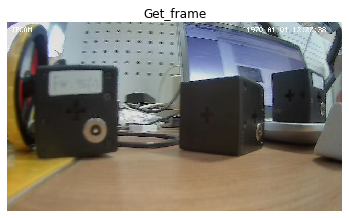

{'registered': 1, 'unregistered': 0}
accum_prediction: {'registered': 1.0}
등록된 차량입니다. 주차바가 자동으로 올라갑니다.
Write data: FF FF 04 00 10 00 C1 00 13 02 01 00 02 03 84 00 00 01 F4
Write data: FF FF 04 00 10 00 C1 00 13 02 01 00 02 FC 7C 00 00 01 F4
진입하십시오! 주차장에 오신 것을 환영합니다.


In [7]:
# 프레임을 평가하는 인스턴스 생성. 누적 프레임은 5초 동안 보관.
frames_predictor = PingPongThreadInstance.FramesPredictor(model=model, timer_sec=5)
# 웹캠을 이용하여 번호판을 인식하는 루프.
while True:
    # 주피터 노트북 출력 비우기.
    PingPongThreadInstance.clear_output()
    # 현재 웹캠 프레임을 보여주고 가져오기.
    frame = PingPongThreadInstance.webcam_get_frame(window="Get_frame")
    # 현재 프레임을 평가하고, 평가 내용을 누적.
    frame_prediction = frames_predictor.image_predict_and_accum(frame)
    print(frame_prediction)
    # 누적된 평가 내용.
    accum_prediction = frames_predictor.accum_predict()
    # 누적된 평가 내용이 없으면 돌아가기. 아니면 가장 확률이 높은 클래스 확인.
    if accum_prediction == None:
        max_class = None
        continue
    else:
        print("accum_prediction:", accum_prediction)
        # 가장 확률이 높은 클래스.
        max_class = max(accum_prediction, key=accum_prediction.get)
    # '등록 차량'일 확률이 90% 이상일 때, 주차바를 올리는 작업 진행.
    if max_class == "registered" and accum_prediction[max_class] > 0.9:
        print("등록된 차량입니다. 주차바가 자동으로 올라갑니다.")
        time.sleep(2)
        # 90도만큼 시계방향으로 회전. 이후 2초 쉬기.
        angle = 90/360
        PingPongThreadInstance.run_motor_step(1, 15, angle)
        time.sleep(angle/15*60+2)
        # 90도만큼 반시계방향으로 회전. 
        PingPongThreadInstance.run_motor_step(1, 15, -angle)
        time.sleep(angle/15*60)
        print("진입하십시오! 주차장에 오신 것을 환영합니다.")
        time.sleep(2)
        break
    # '미등록 차량'일 확률이 90% 이상일 때, 경고음 재생.
    elif max_class == "unregistered" and accum_prediction[max_class] > 0.9:
        # 1박자로 '도' 연주.
        PingPongThreadInstance.play_music(1, ["do"], ["whole"])
        print("죄송합니다. 이 번호는 등록되지 않은 차량이오니 등록 후 주차장을 이용하여 주시기 부탁드립니다.")
        break
    # 모두 아니면 돌아가기.
    else:
        continue

In [8]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()
# 로봇 제어 쓰레드 종료.
PingPongThreadInstance.end()
# 로봇 제어 쓰레드 인스턴스 삭제.
del PingPongThreadInstance

Write data: FF FF FF FF 00 00 A8 00 0A 01
Disconnect master robot.
Serial disconnected. Sleep 3 seconds.
End thread.


In [ ]:
# 커널 재시작. 
import os
os._exit(00)

In [ ]:
# 상위 폴더 경로 가져오기.
from example_base import GetParentPath
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread

# 2개 로봇을 연결하는 인스턴스 생성.
PingPongThreadInstance = PingPongThread(number=2) # n개 로봇 연결
PingPongThreadInstance.start() # 쓰레드 시작
PingPongThreadInstance.wait_until_full_connect() # 전부 연결될 때까지 기다림

In [ ]:
# 시간 제어를 위한 모듈 import.
import time
# 키보드 제어를 위한 모듈 import.
import keyboard

# 로봇을 조작하는 루프 생성.
angle = 90/360
while True:
    # '위' 키를 누르면 90도만큼 1번 큐브를 반시계 방향으로 회전, 2번 큐브를 시계 방향으로 회전.
    if keyboard.is_pressed("up"):
        PingPongThreadInstance.run_motor_step([1, 2], 15, [-angle, angle])
        time.sleep(angle/15*60)
    # '아래' 키를 누르면 90도만큼 1번 큐브를 시계 방향으로 회전, 2번 큐브를 반시계 방향으로 회전.
    elif keyboard.is_pressed("down"):
        PingPongThreadInstance.run_motor_step([1, 2], 15, [angle, -angle])
        time.sleep(angle/15*60)
    # '왼쪽' 키를 누르면 90도만큼 1번 큐브를 시계 방향으로 회전, 2번 큐브를 시계 방향으로 회전.
    elif keyboard.is_pressed("left"):
        PingPongThreadInstance.run_motor_step([1, 2], 15, [angle, angle])
        time.sleep(angle/15*60)
    # '오른쪽' 키를 누르면 90도만큼 1번 큐브를 반시계 방향으로 회전, 2번 큐브를 반시계 방향으로 회전.
    elif keyboard.is_pressed("right"):
        PingPongThreadInstance.run_motor_step([1, 2], 15, [-angle, -angle])
        time.sleep(angle/15*60)
    # 'q' 키를 누르면 종료.
    elif keyboard.is_pressed("q"):
        break
    else:
        time.sleep(0.1)

In [ ]:
# 로봇 제어 쓰레드 종료.
PingPongThreadInstance.end()